In [1]:
import scanpy as sc
import pandas as pd
import os

BASE_DIR = os.getcwd()

In [2]:
adata = sc.read_10x_h5(
    filename=os.path.join(
        BASE_DIR, "data", "5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5"
    ),
    gex_only=False,
)
adata.var_names_make_unique()

/home/malte/Dokumente/Github/citeseq_to_fcs/venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
# Filter for Citeseq data
adata_citeseq = adata[:, adata.var["feature_types"] == "Antibody Capture"]

In [4]:
gen_data = pd.DataFrame(adata_citeseq.X.toarray())
gen_data.columns = pd.Series(adata_citeseq.var.index)

In [5]:
# Add column for barcode
gen_data["barcode_rank"] = pd.Series(range(len(gen_data)))

In [6]:
adata_citeseq

View of AnnData object with n_obs × n_vars = 5527 × 32
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'

### Generate FCS file

In [12]:
import flowio
import numpy as np
import flowutils

FCS_OUTPUT_FILENAME = os.path.join(BASE_DIR, "data", "citeseq.fcs")

In [8]:
file_obj = flowio.create_fcs(
    file_handle=open(FCS_OUTPUT_FILENAME, mode="wb"),
    event_data=np.column_stack(
        [adata_citeseq.X.toarray(), np.array(range(len(adata_citeseq.obs)))]
    ).flatten(),
    channel_names=adata_citeseq.var.index.tolist() + ["barcode_rank"],
)
file_obj.close()

In [9]:
fcs_data = flowio.FlowData(FCS_OUTPUT_FILENAME)

In [10]:
pd.DataFrame(np.reshape(fcs_data.events, (-1, fcs_data.channel_count))).head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,12.0,280.0,9.0,3122.0,746.0,9.0,1.0,5.0,2.0,4.0,...,2.0,6.0,8.0,4.0,101.0,4.0,5.0,2.0,4.0,0.0
1,24.0,231.0,11.0,1241.0,355.0,10.0,2.0,4.0,11.0,5.0,...,1.0,4.0,8.0,8.0,1450.0,5.0,0.0,1.0,1.0,1.0
2,23.0,117.0,3.0,582.0,133.0,7.0,4.0,1.0,7.0,3.0,...,4.0,5.0,2.0,2.0,524.0,2.0,1.0,4.0,2.0,2.0
3,8.0,83.0,1.0,1966.0,675.0,7.0,2.0,3.0,8.0,3.0,...,3.0,2.0,2.0,5.0,216.0,0.0,5.0,1.0,3.0,3.0
4,726.0,1100.0,5.0,14.0,13.0,6.0,2.0,7.0,6.0,11.0,...,2.0,129.0,4.0,5.0,9.0,5.0,1.0,3.0,4.0,4.0


In [11]:
# Check if arrays are the same
(
    np.reshape(fcs_data.events, (-1, fcs_data.channel_count))[
        :, : fcs_data.channel_count - 1
    ]
    == adata_citeseq.X.toarray()
).all()

True

In [18]:
comp_df = pd.DataFrame(
    np.reshape(fcs_data.events, (-1, fcs_data.channel_count)),
    columns=[v["PnN"] for v in fcs_data.channels.values()],
)
comp_df

,CD3_TotalSeqB,CD4_TotalSeqB,CD8a_TotalSeqB,CD11b_TotalSeqB,CD14_TotalSeqB,CD15_TotalSeqB,CD16_TotalSeqB,CD19_TotalSeqB,CD20_TotalSeqB,CD25_TotalSeqB,...,CD274_TotalSeqB,CD278_TotalSeqB,CD335_TotalSeqB,PD-1_TotalSeqB,HLA-DR_TotalSeqB,TIGIT_TotalSeqB,IgG1_control_TotalSeqB,IgG2a_control_TotalSeqB,IgG2b_control_TotalSeqB,barcode_rank
0,12.0,280.0,9.0,3122.0,746.0,9.0,1.0,5.0,2.0,4.0,...,2.0,6.0,8.0,4.0,101.0,4.0,5.0,2.0,4.0,0.0
1,24.0,231.0,11.0,1241.0,355.0,10.0,2.0,4.0,11.0,5.0,...,1.0,4.0,8.0,8.0,1450.0,5.0,0.0,1.0,1.0,1.0
2,23.0,117.0,3.0,582.0,133.0,7.0,4.0,1.0,7.0,3.0,...,4.0,5.0,2.0,2.0,524.0,2.0,1.0,4.0,2.0,2.0
3,8.0,83.0,1.0,1966.0,675.0,7.0,2.0,3.0,8.0,3.0,...,3.0,2.0,2.0,5.0,216.0,0.0,5.0,1.0,3.0,3.0
4,726.0,1100.0,5.0,14.0,13.0,6.0,2.0,7.0,6.0,11.0,...,2.0,129.0,4.0,5.0,9.0,5.0,1.0,3.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5522,472.0,972.0,4.0,8.0,10.0,7.0,1.0,3.0,3.0,2.0,...,2.0,19.0,3.0,4.0,11.0,1.0,3.0,3.0,4.0,5522.0
5523,7.0,192.0,7.0,1820.0,999.0,14.0,2.0,2.0,7.0,9.0,...,3.0,5.0,4.0,2.0,964.0,2.0,2.0,1.0,1.0,5523.0
5524,279.0,6.0,331.0,7.0,11.0,8.0,3.0,4.0,4.0,7.0,...,3.0,3.0,4.0,1.0,7.0,0.0,1.0,2.0,3.0,5524.0
5525,11.0,133.0,10.0,1727.0,745.0,8.0,3.0,9.0,44.0,4.0,...,1.0,4.0,1.0,5.0,274.0,2.0,5.0,2.0,5.0,5525.0


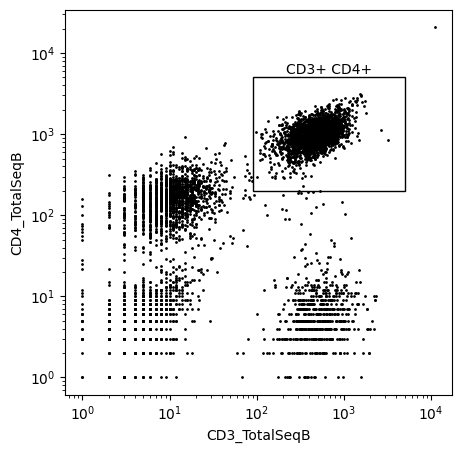

In [47]:
from typing import TypeAlias, Literal
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

ScaleType: TypeAlias = Literal["linear", "log", "symlog", "logit"]


def plot(
    data: pd.DataFrame,
    x: str,
    y: str,
    xscale: ScaleType = "log",
    yscale: ScaleType = "log",
    density: bool = False,
):
    _fig, _ax = plt.subplots(figsize=(5, 5))

    if density is True:
        values = np.vstack(
            [
                data[x].sample(n=1000, random_state=1),
                data[y].sample(n=1000, random_state=1),
            ]
        )
        kernel = stats.gaussian_kde(values)
        density_color = kernel(np.vstack([data[x], data[y]]))
        _ax.scatter(x=data[x], y=data[y], c=density_color, s=1, cmap="jet")
    else:
        _ax.scatter(x=data[x], y=data[y], c="black", s=1)

    _ax.set_xscale(xscale)
    _ax.set_yscale(yscale)
    _ax.set_xlabel(x)
    _ax.set_ylabel(y)

    poly = Polygon(
        [[90, 200], [5000, 200], [5000, 5000], [90, 5000]],
        closed=True,
        edgecolor="black",
        facecolor="none",
    )
    _ax.add_patch(poly)
    _ax.annotate(
        text="CD3+ CD4+",
        xy=(np.exp(((np.log(5000) - np.log(90)) / 2) + np.log(90)), 5000 * 1.1),
        ha="center",
    )

    return _fig, _ax


fig, ax = plot(data=comp_df, x="CD3_TotalSeqB", y="CD4_TotalSeqB")

In [ ]:
def point_in_polygon(point, polygon):
    """Checking if a point is inside a polygon."""
    num_vertices = len(polygon)
    x, y = point[0], point[1]
    inside = False
    p1 = polygon[0]

    for i in range(1, num_vertices + 1):
        p2 = polygon[i % num_vertices]
        if y > min(p1[1], p2[1]):
            if y <= max(p1[1], p2[1]):
                if x <= max(p1[0], p2[0]):
                    x_intersection = (y - p1[1]) * (p2[0] - p1[0]) / (
                        p2[1] - p1[1]
                    ) + p1[0]

                    if p1[0] == p2[0] or x <= x_intersection:
                        inside = not inside
        p1 = p2

    return inside


in_polygon = []
for p in comp_df[["CD3_TotalSeqB", "CD4_TotalSeqB"]].to_numpy():
    in_polygon.append(
        point_in_polygon(p, [[90, 200], [5000, 200], [5000, 5000], [90, 5000]])
    )

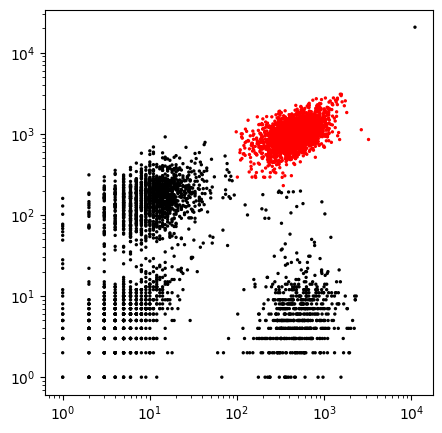

In [112]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(
    x=comp_df["CD3_TotalSeqB"],
    y=comp_df["CD4_TotalSeqB"],
    s=2,
    c=(["red" if x is True else "black" for x in in_polygon]),
)
ax.set_xscale("log")
ax.set_yscale("log")

In [49]:
comp_df

,CD3_TotalSeqB,CD4_TotalSeqB,CD8a_TotalSeqB,CD11b_TotalSeqB,CD14_TotalSeqB,CD15_TotalSeqB,CD16_TotalSeqB,CD19_TotalSeqB,CD20_TotalSeqB,CD25_TotalSeqB,...,CD274_TotalSeqB,CD278_TotalSeqB,CD335_TotalSeqB,PD-1_TotalSeqB,HLA-DR_TotalSeqB,TIGIT_TotalSeqB,IgG1_control_TotalSeqB,IgG2a_control_TotalSeqB,IgG2b_control_TotalSeqB,barcode_rank
0,12.0,280.0,9.0,3122.0,746.0,9.0,1.0,5.0,2.0,4.0,...,2.0,6.0,8.0,4.0,101.0,4.0,5.0,2.0,4.0,0.0
1,24.0,231.0,11.0,1241.0,355.0,10.0,2.0,4.0,11.0,5.0,...,1.0,4.0,8.0,8.0,1450.0,5.0,0.0,1.0,1.0,1.0
2,23.0,117.0,3.0,582.0,133.0,7.0,4.0,1.0,7.0,3.0,...,4.0,5.0,2.0,2.0,524.0,2.0,1.0,4.0,2.0,2.0
3,8.0,83.0,1.0,1966.0,675.0,7.0,2.0,3.0,8.0,3.0,...,3.0,2.0,2.0,5.0,216.0,0.0,5.0,1.0,3.0,3.0
4,726.0,1100.0,5.0,14.0,13.0,6.0,2.0,7.0,6.0,11.0,...,2.0,129.0,4.0,5.0,9.0,5.0,1.0,3.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5522,472.0,972.0,4.0,8.0,10.0,7.0,1.0,3.0,3.0,2.0,...,2.0,19.0,3.0,4.0,11.0,1.0,3.0,3.0,4.0,5522.0
5523,7.0,192.0,7.0,1820.0,999.0,14.0,2.0,2.0,7.0,9.0,...,3.0,5.0,4.0,2.0,964.0,2.0,2.0,1.0,1.0,5523.0
5524,279.0,6.0,331.0,7.0,11.0,8.0,3.0,4.0,4.0,7.0,...,3.0,3.0,4.0,1.0,7.0,0.0,1.0,2.0,3.0,5524.0
5525,11.0,133.0,10.0,1727.0,745.0,8.0,3.0,9.0,44.0,4.0,...,1.0,4.0,1.0,5.0,274.0,2.0,5.0,2.0,5.0,5525.0
